In [21]:
# Only if kagglehub is not already installed
!pip install kagglehub --quiet

# Core libs
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.manifold import TSNE

import os, glob, textwrap

# Plot style
plt.rcParams["figure.figsize"] = (8, 5)
sns.set(style="whitegrid")


In [22]:
import kagglehub

path = kagglehub.dataset_download("ihormuliar/starbucks-customer-data")
print("Path to dataset files:", path)

# Example output:
# /root/.cache/kagglehub/datasets/ihormuliar/starbucks-customer-data/versions/1


Using Colab cache for faster access to the 'starbucks-customer-data' dataset.
Path to dataset files: /kaggle/input/starbucks-customer-data


In [23]:
import os, glob

data_dir = path  # from previous cell

# See what files are inside
files = glob.glob(os.path.join(data_dir, "*"))
files


['/kaggle/input/starbucks-customer-data/transcript.csv',
 '/kaggle/input/starbucks-customer-data/profile.csv',
 '/kaggle/input/starbucks-customer-data/portfolio.csv']

In [24]:
transcript = pd.read_csv(os.path.join(path, "transcript.csv"))
profile     = pd.read_csv(os.path.join(path, "profile.csv"))
portfolio   = pd.read_csv(os.path.join(path, "portfolio.csv"))

transcript.head(), profile.head(), portfolio.head()


(   Unnamed: 0                            person           event  \
 0           0  78afa995795e4d85b5d9ceeca43f5fef  offer received   
 1           1  a03223e636434f42ac4c3df47e8bac43  offer received   
 2           2  e2127556f4f64592b11af22de27a7932  offer received   
 3           3  8ec6ce2a7e7949b1bf142def7d0e0586  offer received   
 4           4  68617ca6246f4fbc85e91a2a49552598  offer received   
 
                                               value  time  
 0  {'offer id': '9b98b8c7a33c4b65b9aebfe6a799e6d9'}     0  
 1  {'offer id': '0b1e1539f2cc45b7b9fa7c272da2e1d7'}     0  
 2  {'offer id': '2906b810c7d4411798c6938adc9daaa5'}     0  
 3  {'offer id': 'fafdcd668e3743c1bb461111dcafc2a4'}     0  
 4  {'offer id': '4d5c57ea9a6940dd891ad53e9dbe8da0'}     0  ,
    Unnamed: 0 gender  age                                id  became_member_on  \
 0           0    NaN  118  68be06ca386d4c31939f3a4f0e3dd783          20170212   
 1           1      F   55  0610b486422d4921ae7d2bf64640c50

In [25]:
def inspect(df, name):
    print("=====", name, "=====")
    print(df.shape)
    print(df.info())
    print(df.isna().sum(), "\n")

inspect(profile, "PROFILE")
inspect(portfolio, "PORTFOLIO")
inspect(transcript, "TRANSCRIPT")


===== PROFILE =====
(17000, 6)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17000 entries, 0 to 16999
Data columns (total 6 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Unnamed: 0        17000 non-null  int64  
 1   gender            14825 non-null  object 
 2   age               17000 non-null  int64  
 3   id                17000 non-null  object 
 4   became_member_on  17000 non-null  int64  
 5   income            14825 non-null  float64
dtypes: float64(1), int64(3), object(2)
memory usage: 797.0+ KB
None
Unnamed: 0             0
gender              2175
age                    0
id                     0
became_member_on       0
income              2175
dtype: int64 

===== PORTFOLIO =====
(10, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 7 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  10 non-null     int64 


In [26]:
profile.rename(columns={'id': 'customer_id'}, inplace=True)

profile['became_member_on'] = pd.to_datetime(profile['became_member_on'], format="%Y%m%d")

profile['income'].fillna(profile['income'].median(), inplace=True)

# Remove impossible ages (often age = 118 means missing)
profile = profile[profile['age'] < 100]


In [27]:
portfolio.rename(columns={'id': 'offer_id'}, inplace=True)

# Expand channels column
channels_dummies = portfolio['channels'].apply(lambda x: pd.Series(1, index=x.strip("[]").replace("'", "").split(", ")))
channels_dummies = channels_dummies.fillna(0)

portfolio = pd.concat([portfolio.drop(columns=['channels']), channels_dummies], axis=1)

portfolio.head()


,Unnamed: 0,reward,difficulty,duration,offer_type,offer_id,email,mobile,social,web
0,0,10,10,7,bogo,ae264e3637204a6fb9bb56bc8210ddfd,1.0,1.0,1.0,0.0
1,1,10,10,5,bogo,4d5c57ea9a6940dd891ad53e9dbe8da0,1.0,1.0,1.0,1.0
2,2,0,0,4,informational,3f207df678b143eea3cee63160fa8bed,1.0,1.0,0.0,1.0
3,3,5,5,7,bogo,9b98b8c7a33c4b65b9aebfe6a799e6d9,1.0,1.0,0.0,1.0
4,4,5,20,10,discount,0b1e1539f2cc45b7b9fa7c272da2e1d7,1.0,0.0,0.0,1.0


In [28]:
transcript.rename(columns={'person': 'customer_id'}, inplace=True)

# Extract amount and offer_id from "value" dict
transcript['amount'] = transcript['value'].apply(lambda x: x.get('amount') if isinstance(x, dict) else None)
transcript['offer_id'] = transcript['value'].apply(lambda x: x.get('offer id') if isinstance(x, dict) else
                                                   (x.get('offer_id') if isinstance(x, dict) else None))

transcript.drop(columns=['value'], inplace=True)
transcript.head()


,Unnamed: 0,customer_id,event,time,amount,offer_id
0,0,78afa995795e4d85b5d9ceeca43f5fef,offer received,0,None,None
1,1,a03223e636434f42ac4c3df47e8bac43,offer received,0,None,None
2,2,e2127556f4f64592b11af22de27a7932,offer received,0,None,None
3,3,8ec6ce2a7e7949b1bf142def7d0e0586,offer received,0,None,None
4,4,68617ca6246f4fbc85e91a2a49552598,offer received,0,None,None


In [29]:
transactions = transcript[transcript['event'] == "transaction"]

# Reference time (max time in dataset)
reference_time = transactions['time'].max()

rfm = transactions.groupby("customer_id").agg(
    recency = ('time', lambda x: reference_time - x.max()),
    frequency = ('amount', 'count'),
    monetary = ('amount', 'sum')
).reset_index()
rfm.head()


,customer_id,recency,frequency,monetary
0,0009655768c64bdeb2e877511632db8f,18,0,0
1,00116118485d4dfda04fdbaba9a87b5c,240,0,0
2,0011e0d4e6b944f998e987f904e8c1e5,60,0,0
3,0020c2b971eb4e9188eac86d93036a77,6,0,0
4,0020ccbbb6d84e358d3414a3ff76cffd,42,0,0


In [30]:
offer_events = transcript[transcript['event'] != "transaction"]

offer_counts = offer_events.pivot_table(index='customer_id',
                                        columns='event',
                                        aggfunc='size',
                                        fill_value=0).reset_index()

offer_counts.head()


event,customer_id,offer completed,offer received,offer viewed
0,0009655768c64bdeb2e877511632db8f,3,5,4
1,00116118485d4dfda04fdbaba9a87b5c,0,2,2
2,0011e0d4e6b944f998e987f904e8c1e5,3,5,5
3,0020c2b971eb4e9188eac86d93036a77,3,5,3
4,0020ccbbb6d84e358d3414a3ff76cffd,3,4,4


In [31]:
customer_df = profile.merge(rfm, on='customer_id', how='left')
customer_df = customer_df.merge(offer_counts, on='customer_id', how='left')

customer_df.fillna(0, inplace=True)
customer_df.head()


,Unnamed: 0,gender,age,customer_id,became_member_on,income,recency,frequency,monetary,offer completed,offer received,offer viewed
0,1,F,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,186.0,0.0,0,1.0,2.0,0.0
1,3,F,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,180.0,0.0,0,3.0,4.0,4.0
2,5,M,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,192.0,0.0,0,2.0,4.0,3.0
3,8,M,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,114.0,0.0,0,5.0,6.0,6.0
4,12,M,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,144.0,0.0,0,1.0,3.0,2.0


In [32]:
customer_df = pd.get_dummies(customer_df, columns=['gender'], drop_first=True)
customer_df.head()


,Unnamed: 0,age,customer_id,became_member_on,income,recency,frequency,monetary,offer completed,offer received,offer viewed,gender_M,gender_O
0,1,55,0610b486422d4921ae7d2bf64640c50b,2017-07-15,112000.0,186.0,0.0,0,1.0,2.0,0.0,False,False
1,3,75,78afa995795e4d85b5d9ceeca43f5fef,2017-05-09,100000.0,180.0,0.0,0,3.0,4.0,4.0,False,False
2,5,68,e2127556f4f64592b11af22de27a7932,2018-04-26,70000.0,192.0,0.0,0,2.0,4.0,3.0,True,False
3,8,65,389bc3fa690240e798340f5a15918d5c,2018-02-09,53000.0,114.0,0.0,0,5.0,6.0,6.0,True,False
4,12,58,2eeac8d8feae4a8cad5a6af0499a211d,2017-11-11,51000.0,144.0,0.0,0,1.0,3.0,2.0,True,False


In [33]:
features = [
    "age", "income", "recency", "frequency", "monetary",
    "offer received", "offer viewed", "offer completed"
]

X = customer_df[features].copy()


In [34]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


In [35]:
pca = PCA(n_components=0.90)   # keep 90% variance
X_pca = pca.fit_transform(X_scaled)

print("Original dims:", X_scaled.shape[1])
print("Reduced dims:", X_pca.shape[1])


Original dims: 8
Reduced dims: 5


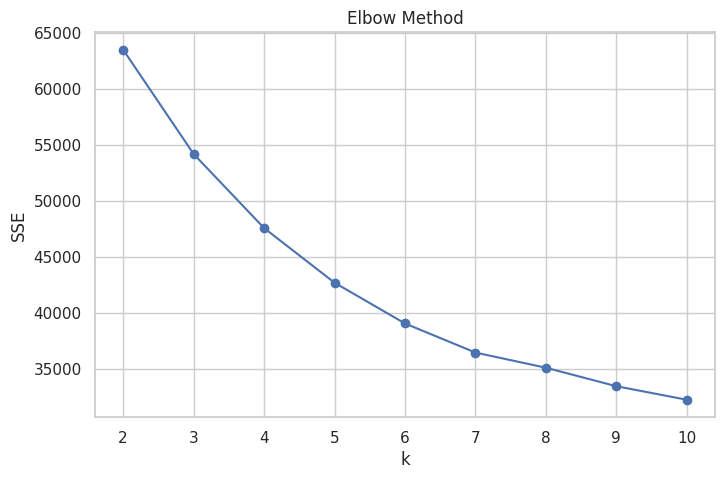

In [36]:
sse = []
K = range(2, 11)

for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    km.fit(X_pca)
    sse.append(km.inertia_)

plt.plot(K, sse, marker='o')
plt.xlabel("k")
plt.ylabel("SSE")
plt.title("Elbow Method")
plt.show()


In [37]:
for k in K:
    km = KMeans(n_clusters=k, random_state=42, n_init="auto")
    labels = km.fit_predict(X_pca)
    sil = silhouette_score(X_pca, labels)
    print(f"k={k} → silhouette={sil:.4f}")


k=2 → silhouette=0.2135
k=3 → silhouette=0.1978
k=4 → silhouette=0.2000
k=5 → silhouette=0.1831
k=6 → silhouette=0.1874
k=7 → silhouette=0.1787
k=8 → silhouette=0.1779
k=9 → silhouette=0.1710
k=10 → silhouette=0.1649


In [38]:
best_k = 6  # ← change based on your silhouette results

kmeans = KMeans(n_clusters=best_k, random_state=42, n_init="auto")
customer_df["cluster"] = kmeans.fit_predict(X_pca)

customer_df["cluster"].value_counts()


,count
cluster,
3,3059
2,2808
0,2790
4,2432
1,2398
5,1321


In [39]:
customer_df.groupby("cluster")[features].mean()


,age,income,recency,frequency,monetary,offer received,offer viewed,offer completed
cluster,,,,,,,,
0,32.301075,50415.053763,58.034409,0.0,0.0,4.726882,3.381004,1.815412
1,65.450375,52459.966639,55.991660,0.0,0.0,4.861551,3.622602,1.230192
2,64.829772,91459.045584,69.260684,0.0,0.0,4.208333,3.042379,2.792023
3,56.847009,69223.929389,61.659366,0.0,0.0,5.430860,4.744034,4.089245
4,51.425576,56642.269737,73.058388,0.0,0.0,3.053043,1.867188,1.017681
5,57.990159,72350.492051,272.716124,0.0,0.0,4.334595,3.093111,1.180924


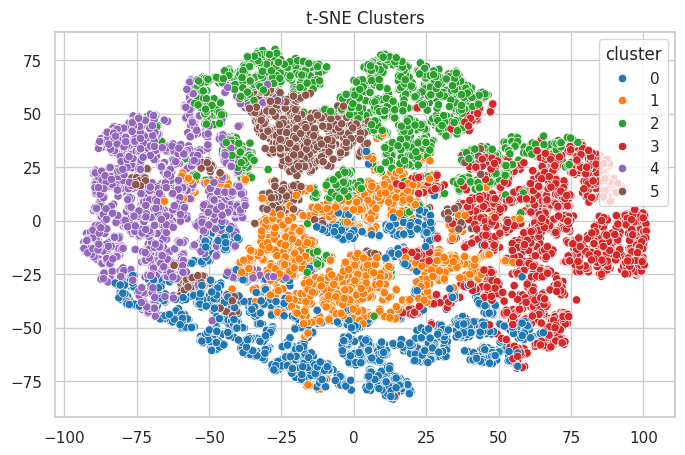

In [40]:
tsne = TSNE(n_components=2, perplexity=40, random_state=42)
tsne_results = tsne.fit_transform(X_pca)

plt.figure(figsize=(8,5))
sns.scatterplot(x=tsne_results[:,0], y=tsne_results[:,1],
                hue=customer_df["cluster"], palette="tab10")
plt.title("t-SNE Clusters")
plt.show()
